In [1]:
import numpy as np                      # I use this for maths and sometimes arrays.
                                        # "np" is just an abbreviation since we call this package so often!
import pylab                            # I use this for arrays and plotting
import matplotlib                       # Another plotting package
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  # If there is a task you use a lot, importing it like this 
                                         # keeps you from having to constantly type "matplotlib.gridspec"
                                        # every time you call that task!
        
import scipy
import astropy.io.fits as fits          # I use this to import FITS images. 
                                        # Astropy should be included in your conda installation
from astropy.wcs import WCS             # This one helps us add coordinates to images
import pyspeckit as psk                 # I use this to do spectral line fitting
                                        #Anna: Had to install using an anaconda terminal window, its located at Users\Anna\AppData\Local\pip

from astropy.nddata import Cutout2D     #To make image cut outs

    
# Super important: This embeds plots in the Jupyter window (instead of showing them as pop-ups)
%matplotlib inline                             

#Set plot fonts
matplotlib.rc('text', usetex=True) #Change to True later if Latex is installed
matplotlib.rc('font', family='sans-serif')


In [13]:
# This file is higher-resolution version of the same data

path = 'ngc253_cont_super.fits'
image = fits.getdata(path)  
header = fits.getheader(path)

print(header) #You can print the entire header just to see its contents

w = WCS(header) 
print(w)
print("The current image shape is: ", np.shape(image))

#Can see from the header and image shape that we need to get rid of two of the four axes like in the tutorial
w = w.dropaxis(3) #NAXIS 4
w = w.dropaxis(2) #NAXIS 3
image_2D = pylab.squeeze(image) #gets rid of axes with length 1


#Now check the image shape again:
print("The new image shape is: ", np.shape(image_2D))



SIMPLE  =                    T /Standard FITS                                   BITPIX  =                  -32 /Floating point (32 bit)                         NAXIS   =                    4                                                  NAXIS1  =                 2500                                                  NAXIS2  =                 1500                                                  NAXIS3  =                    1                                                  NAXIS4  =                    1                                                  EXTEND  =                    T                                                  BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 BZERO   =   0.000000000000E+00                                                  BMAJ    =   3.069593053725E-05                                                  BMIN    =   2.499944219987E-05                                                  BPA     =  -6.239358901978E+01          

PC01_01 = 1.000000000000E+00 
indices in parameterized keywords must not have leading zeroes.
PC02_01 = 0.000000000000E+00 
indices in parameterized keywords must not have leading zeroes.
PC03_01 = 0.000000000000E+00 
indices in parameterized keywords must not have leading zeroes.
PC04_01 = 0.000000000000E+00 
indices in parameterized keywords must not have leading zeroes.
PC01_02 = 0.000000000000E+00 
indices in parameterized keywords must not have leading zeroes.
PC02_02 = 1.000000000000E+00 
indices in parameterized keywords must not have leading zeroes.
PC03_02 = 0.000000000000E+00 
indices in parameterized keywords must not have leading zeroes.
PC04_02 = 0.000000000000E+00 
indices in parameterized keywords must not have leading zeroes.
PC01_03 = 0.000000000000E+00 
indices in parameterized keywords must not have leading zeroes.
PC02_03 = 0.000000000000E+00 
indices in parameterized keywords must not have leading zeroes.
PC03_03 = 1.000000000000E+00 
indices in parameterized keywo

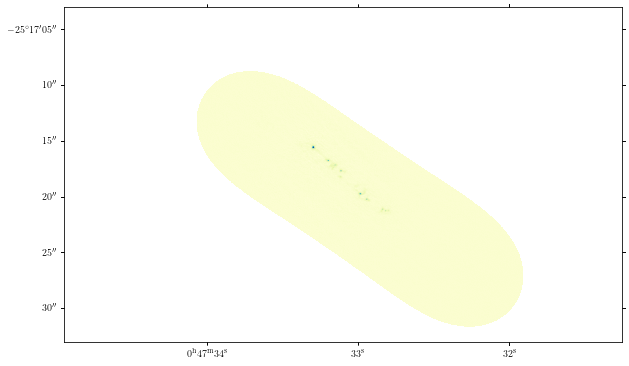

In [6]:
fig1 = pylab.figure(1,figsize=(10,10))
ax1 = pylab.subplot(projection=w)
im1 = pylab.imshow(image_2D,cmap='YlGnBu')

In [36]:
#Now to turn this into a mass map
#Continuum map is in Jy/Beam, need to convert to Jy/pixel
#Mult by beam area, divide by pixel area

#1:Find beam area in arcseconds, beam area is in terms of FWHM, bmin and bmax, each divided by 2.35, then
print( "Beam major is:" , header['BMAJ'], "and Beam minor is:", header['BMIN'], "in degrees.")
#Convert degrees to arcseconds:
bmaj = header['BMAJ'] * 3600
bmin = header['BMIN'] *3600
print("bmaj:", bmaj, "bmin:", bmin, "in arcseconds.")
#divide by 2.35 to take care of the FWHM:
bmaj = bmaj/2.35
bmin = bmin/2.35
print("Divided by 2.35:", bmaj, bmin)
# Area in arcsec^2 = 2*pi*min*max
pi = np.pi
beam_A = 2*pi*bmaj*bmin
print("Beam area in arcseconds squared:", beam_A)

#2: Find pixel area
cdelt1 = -1 * header['CDELT1'] #idk why but CDELT1 is negative which doesn't make sense to me, so I made it positive
cdelt2 = header['CDELT2']
print("pixel area is", cdelt1, "by", cdelt2)
#convert degrees to arcseconds:
cdelt1 = cdelt1 *3600
cdelt2 = cdelt2 *3600
print("cdelt1 is", cdelt1, "and cdelt2 is", cdelt2, "in arcseconds.")
#pixel area:
pix_A = cdelt1*cdelt2
print("Pixel area is", pix_A, "in arcseconds squared")

#3: Finally, the conversion from Jy/beam to Jy/pixel will be L(in Jy/beam) * beam_A / pix_A
image_2D = image_2D * beam_A / pix_A #(converts Jy/beam to Jy/pixel)

#Now to convert from luminosity to a mass:
#Equ. 13 from Scoville 2016, Appendix 4, pg 15: L/M = 6.7*10^19 ergs/s/Hz/M = alpha
#We already converted L to Jy/pixel to be more useful units, but now we need to take care of a couple other units as well
#Using 1 Jy = 10^-23 ergs/s/cm^2/Hz: our given L (now in Jy/pixel) = L*10^-23 ergs/s/cm^2/Hz
#Ignore the per pixel part since we perform the transformation on each pixel
#so now we have ergs/s/cm^2/Hz, looking at our conversion factor, alpha, we still need to take care of /cm^2
#mult by distance to the galaxy squared. D = 3.5Mpc = 1.08*10^25, so L*10^-23 ergs/s/cm^2/Hz *(1.08*10^25cm)^2 = 
# ergs/s/Hz -- now units match alpha! and if we divide by alpha, we get solar masses
image_2D = image_2D * (10**-23) * (1.08 * (10**25)**2) #converts to ergs/s/Hz
#L/M = 6.7*10^19 ergs/s/Hz/M = alpha
alpha = 6.7 * (10**19)
image_mass = image_2D / alpha

Beam major is: 3.069593053725e-05 and Beam minor is: 2.499944219987e-05 in degrees.
bmaj: 0.11050534993410001 bmin: 0.08999799191953199 in arcseconds.
Divided by 2.35: 0.04702355316344681 0.03829701783809872
Beam area in arcseconds squared: 0.01131514874326898
pixel area is 5.555555555556e-06 by 5.555555555556e-06
cdelt1 is 0.0200000000000016 and cdelt2 is 0.0200000000000016 in arcseconds.
Pixel area is 0.000400000000000064 in arcseconds squared


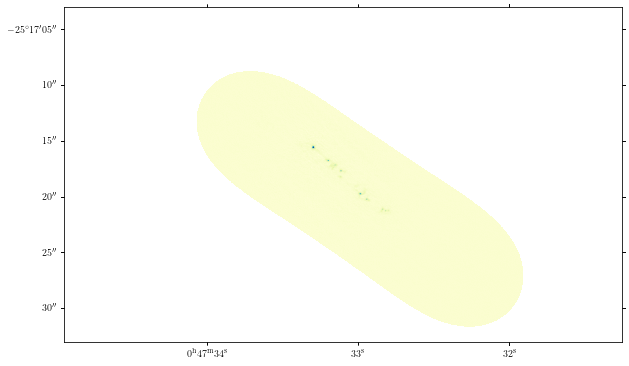

In [37]:
fig2 = pylab.figure(1,figsize=(10,10))
ax2 = pylab.subplot(projection=w)
im2 = pylab.imshow(image_mass,cmap='YlGnBu')